### MODEL SELECTION
### o ML-Models to be used:
### 1. Random Forest
### 2. SVM
### 3. Logistic Regression
### 4. KNN
### 5. Naive Bayes

### o DL-Models to be used:
### 1. Convolutional Neural Network (CNN) : PyTorch
### 2. Fully Connected Neural Network/Dense network : TensorFlow
### 3. Convolutional Neural Network (CNN) : TensorFlow

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow import keras

In [2]:
# Step 1: Load preprocessed data
train_df = pd.read_csv("../2PREPROCESSING/Processed_CSV/cropped_train.csv")
test_df = pd.read_csv("../2PREPROCESSING/Processed_CSV/cropped_test.csv")

# Separate features (X) and labels (y)
X_train, y_train = train_df.iloc[:, 1:].values, train_df.iloc[:, 0].values
X_test, y_test = test_df.iloc[:, 1:].values, test_df.iloc[:, 0].values

# Normalize data using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
# Store results for comparison
results = []

# Step 2: Train Machine Learning models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel="rbf"),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='macro'),
        "Recall": recall_score(y_test, y_pred, average='macro'),
        "F1-Score": f1_score(y_test, y_pred, average='macro'),
        "Training Time (s)": round(end_time - start_time, 2)
    })

In [ ]:
# Step 3: Train Deep Learning models (Using GPU for acceleration)
# Convert data for PyTorch & TensorFlow
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=128, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# PyTorch CNN Model
class CNNModel(nn.Module):
    def __init__(self, input_size):
        super(CNNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

cnn_model = CNNModel(X_train.shape[1]).to(device)
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train PyTorch CNN
start_time = time.time()
for epoch in range(5):  # 5 epochs for speed
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
end_time = time.time()

# Evaluate PyTorch CNN
cnn_model.eval()
y_pred_cnn = cnn_model(X_test_tensor.to(device)).argmax(dim=1).cpu().numpy()

results.append({
    "Model": "CNN (PyTorch)",
    "Accuracy": accuracy_score(y_test, y_pred_cnn),
    "Precision": precision_score(y_test, y_pred_cnn, average='macro'),
    "Recall": recall_score(y_test, y_pred_cnn, average='macro'),
    "F1-Score": f1_score(y_test, y_pred_cnn, average='macro'),
    "Training Time (s)": round(end_time - start_time, 2)
})

# TensorFlow Fully Connected Neural Network
tf_model = keras.Sequential([
    keras.layers.Dense(256, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

tf_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
start_time = time.time()
tf_model.fit(X_train, y_train, epochs=5, batch_size=128, verbose=0)
end_time = time.time()

y_pred_tf = np.argmax(tf_model.predict(X_test), axis=1)

results.append({
    "Model": "Dense NN (TF)",
    "Accuracy": accuracy_score(y_test, y_pred_tf),
    "Precision": precision_score(y_test, y_pred_tf, average='macro'),
    "Recall": recall_score(y_test, y_pred_tf, average='macro'),
    "F1-Score": f1_score(y_test, y_pred_tf, average='macro'),
    "Training Time (s)": round(end_time - start_time, 2)
})

# TensorFlow CNN Model
cnn_tf = keras.Sequential([
    keras.layers.Reshape((20, 20, 1), input_shape=(X_train.shape[1],)),    
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

cnn_tf.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
start_time = time.time()
cnn_tf.fit(X_train, y_train, epochs=5, batch_size=128, verbose=0)
end_time = time.time()

y_pred_tf_cnn = np.argmax(cnn_tf.predict(X_test), axis=1)

results.append({
    "Model": "CNN (TF)",
    "Accuracy": accuracy_score(y_test, y_pred_tf_cnn),
    "Precision": precision_score(y_test, y_pred_tf_cnn, average='macro'),
    "Recall": recall_score(y_test, y_pred_tf_cnn, average='macro'),
    "F1-Score": f1_score(y_test, y_pred_tf_cnn, average='macro'),
    "Training Time (s)": round(end_time - start_time, 2)
})

c:\Users\RONIT\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


c:\Users\RONIT\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


                 Model  Accuracy  Precision    Recall  F1-Score  \
0        Random Forest    0.9704   0.970116  0.970027  0.970045   
1                  SVM    0.9766   0.976484  0.976311  0.976369   
2  Logistic Regression    0.9233   0.922519  0.922346  0.922375   
3                  KNN    0.9561   0.957116  0.955528  0.955937   
4          Naive Bayes    0.6985   0.750783  0.693985  0.700394   
5        CNN (PyTorch)    0.9773   0.977066  0.977013  0.976997   
6        Dense NN (TF)    0.9775   0.977451  0.977179  0.977263   
7             CNN (TF)    0.9841   0.983970  0.984020  0.983928   

   Training Time (s)  
0              37.90  
1             156.30  
2               7.82  
3               3.56  
4               0.59  
5               5.09  
6               5.85  
7              16.02  


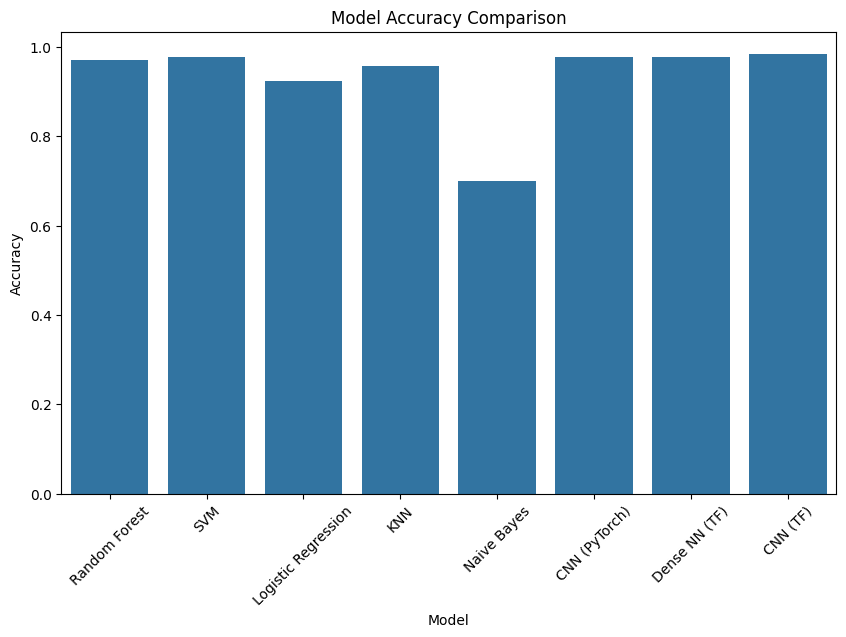

In [5]:
# Step 4: Compare Results
results_df = pd.DataFrame(results)
print(results_df)

# Plot Model Accuracy Comparison
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x="Model", y="Accuracy")
plt.xticks(rotation=45)
plt.title("Model Accuracy Comparison")
plt.show()

In [6]:
# Find the best ML and DL algorithms based on Accuracy
best_ml = max(results[:5], key=lambda x: x["Accuracy"])["Model"]  # First 5 are ML
best_dl = max(results[5:], key=lambda x: x["Accuracy"])["Model"]  # Last 3 are DL

print(f"Best ML algorithm is {best_ml} and best DL algorithm is {best_dl}.")

Best ML algorithm is SVM and best DL algorithm is CNN (TF).


In [7]:
import os
import joblib

# Define directories for saving models
model_dir = "../3MODEL_SELECTION/MODELS"
ml_model_dir = os.path.join(model_dir, "ML_models")
dl_model_dir = os.path.join(model_dir, "DL_models")

# Create directories if they don’t exist
os.makedirs(ml_model_dir, exist_ok=True)
os.makedirs(dl_model_dir, exist_ok=True)

# Save all trained ML models
for name, model in models.items():
    model_path = os.path.join(ml_model_dir, f"{name.replace(' ', '_')}.pkl")
    joblib.dump(model, model_path)
    print(f"Saved ML model: {name} at {model_path}")

# Save the trained PyTorch CNN model
cnn_model_path = os.path.join(dl_model_dir, "CNN_PyTorch.pth")
torch.save(cnn_model.state_dict(), cnn_model_path)
print(f"Saved DL model: CNN (PyTorch) at {cnn_model_path}")

# Save the trained TensorFlow Dense NN model
dense_nn_tf_path = os.path.join(dl_model_dir, "Dense_NN_TF.keras")  # Add .keras extension
tf_model.save(dense_nn_tf_path)
print(f"Saved DL model: Dense NN (TF) at {dense_nn_tf_path}")

# Save the trained TensorFlow CNN model
cnn_tf_path = os.path.join(dl_model_dir, "CNN_TF.keras")  # Add .keras extension
cnn_tf.save(cnn_tf_path)
print(f"Saved DL model: CNN (TF) at {cnn_tf_path}")

Saved ML model: Random Forest at ../3MODEL_SELECTION/MODELS\ML_models\Random_Forest.pkl
Saved ML model: SVM at ../3MODEL_SELECTION/MODELS\ML_models\SVM.pkl
Saved ML model: Logistic Regression at ../3MODEL_SELECTION/MODELS\ML_models\Logistic_Regression.pkl
Saved ML model: KNN at ../3MODEL_SELECTION/MODELS\ML_models\KNN.pkl
Saved ML model: Naive Bayes at ../3MODEL_SELECTION/MODELS\ML_models\Naive_Bayes.pkl
Saved DL model: CNN (PyTorch) at ../3MODEL_SELECTION/MODELS\DL_models\CNN_PyTorch.pth
Saved DL model: Dense NN (TF) at ../3MODEL_SELECTION/MODELS\DL_models\Dense_NN_TF.keras
Saved DL model: CNN (TF) at ../3MODEL_SELECTION/MODELS\DL_models\CNN_TF.keras


In [8]:
# Define the best model directory
best_model_dir = "../3MODEL_SELECTION/MODELS/Best_Model/"
os.makedirs(best_model_dir, exist_ok=True)

# Define the model path
best_model_path = os.path.join(best_model_dir, "CNN_TF.keras")

# Save the CNN (TF) model
cnn_tf.save(best_model_path)

print(f"Best model (CNN TF) saved at: {best_model_path}")

Best model (CNN TF) saved at: ../3MODEL_SELECTION/MODELS/Best_Model/CNN_TF.keras


# best model is of Convolutional Neural Network (CNN) : TensorFlow (accuracy 0.9841)